# Designing a Python library for building prototypes around MinHash

This is very much work-in-progress. May be the software and or ideas presented with be the subject of a peer-reviewed or self-published write-up. For now the URL for this is: https://github.com/lgautier/mashing-pumpkins

MinHash in the context of biological sequenced was introduced by the Maryland Bioinformatics Lab [add reference here].

Building a MinHash is akin to taking a sample of all k-mers / n-grams found in a sequence and using that sample as a signature or sketch for that sequence.

## A look at convenience *vs* performance

Moving Python code to C leads to performance improvement... sometimes.

### Test sequence

First we need a test sequence. Generating a random one quickly can be achieved as follows, for example. If you already have you own way to generate a sequence, or your own benchmark sequence, the following code cell can be changed so as to end up with a variable `sequence` that is a `bytes` object containing it.

In [1]:
# we take a DNA sequence as an example, but this is arbitrary and not necessary.
alphabet = b'ATGC'
# create a lookup structure to go from byte to 4-mer
# (a arbitrary byte is a bitpacked 4-mer)
quad = [None,]*(len(alphabet)**4)
i = 0
for b1 in alphabet:
    for b2 in alphabet:
        for b3 in alphabet:
            for b4 in alphabet:
                quad[i] = bytes((b1,b2,b3,b4))
                i += 1
# random bytes for a 1M genome (order of magnitude for a bacterial genome)
import ssl
size = int(2E6)
sequencebitpacked = ssl.RAND_bytes(int(size/4))
sequence = bytearray(int(size))
for i, b in zip(range(0, len(sequence), 4), sequencebitpacked):
    sequence[i:(i+4)] = quad[b]
sequence = bytes(sequence)

In [2]:
import time
class timedblock(object):
    def __enter__(self):
        self.tenter = time.clock()
        return self

    def __exit__(self, type, value, traceback):
        self.texit = time.clock()

    @property
    def duration(self):
        return self.texit - self.tenter

### Kicking the tires with `sourmash`

The executable `sourmash` is a nice package from the dib-lab implemented in Python and including a library [add reference here]. Perfect for trying out quick what MinHash sketches can do.

We will create a MinHash of maximum size 1000 (1000 elements) and of k-mer size 21 (all ngrams of length 21 across the input sequences will be considered for inclusion in the MinHash. At the time of writing MinHash is implemented in C/C++ and use that as a reference for speed, as we measure the time it takes to process our 1M reference sequence

In [3]:
from sourmash_lib._minhash import MinHash

sequence_str = sequence.decode("utf-8")
with timedblock() as tb:
    smh = MinHash(1000, 21)
    smh.add_sequence(sequence_str)
t_sourmash = tb.duration
print("%.2f seconds / sequence" % t_sourmash)

0.62 seconds / sequence


This is awesome. The sketch for a bacteria-sized DNA sequence can be computed very quickly (about a second on my laptop).

### Redisigning it all for convenience and flexibility

We have redesigned what a class could look like, and implemented that design in Python
foremost for our own convenience and to match the claim of convenience. Now how bad is the impact on performance ?

Our new design allows flexibility with respect to the hash function used, and to initially illustrate our point we use `mmh` an existing Python package wrapping MurmurHash3, the hashing function used in `MASH` and `sourmash`.

In [4]:
# make a hashing function to match our design
import mmh3
def hashfun(sequence, nsize, hbuffer, w=100):
    n = min(len(hbuffer), len(sequence)-nsize+1)
    for i in range(n):
        ngram = sequence[i:(i+nsize)]
        hbuffer[i] = mmh3.hash64(ngram)[0]
    return n

from mashingpumpkins.minhashsketch import MaxHashNgramSketch
        
from array import array
with timedblock() as tb:
    mhs = MaxHashNgramSketch(21, 1000, hashfun)
    mhs.add(sequence, hashbuffer=array("q", [0,]*200))
    
t_basic = tb.duration
print("%.2f seconds / sequence" % (t_basic))
print("Our Python implementation is %.2f times slower." % (t_basic / t_sourmash))

0.99 seconds / sequence
Our Python implementation is 1.59 times slower.


Ah. Our Python implementation only using `mmh3` and the standard library is not slower.

**note: ** the careful reader will not that we have a MaxHash rather than a MinHash. This is so to use algorithms in the Python stan

There is more to it though. The code in "mashingpumpkins" is doing more by keeping track of the k-mer/n-gram along with the hash value in order to allow the generation of inter-operable sketch [add reference to discussion on GitHub].

Our design in computing batches of hash values each time C is reached for MurmurHash3. We have implemented the small C function require to call MurmurHash for several k-mers, and when using it we have interesting performance gains.

In [5]:
from mashingpumpkins._murmurhash3 import hasharray
hashfun = hasharray
        
with timedblock() as tb:
    mhs = MaxHashNgramSketch(21, 1000, hashfun)
    mhs.add(sequence)

t_batch = tb.duration

print("%.2f seconds / sequence" % (t_batch))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))


0.19 seconds / sequence
Our Python implementation is 3.22 times faster.


Wow!

At the time of writing this is approximatively 3 times faster than C-implemented `sourmash`. And we are doing more work (we are keeping the ngrams / kmers associated with hash values).

We can modifying our class to stop storing the associated k-mer (only keep the hash value) to see if it improves performances:

However, as it was pointed out sourmash's minhash also checking that the sequenceo only uses letters from the DNA alphabet **and** computes the sketch for both the sequence and its reverse complement. We add these 2 operations (check and reverse complement) in a custom child class:

In [6]:
from mashingpumpkins._murmurhash3 import hasharray
hashfun = hasharray

from array import array

trans_tbl = bytearray(256)
for x,y in zip(b'ATGC', b'TACG'):
    trans_tbl[x] = y

def revcomp(sequence):
    ba = bytearray(sequence)
    ba.reverse()
    ba = ba.translate(trans_tbl)
    return ba
    
class MyMash(MaxHashNgramSketch):
    def add(self, seq, hashbuffer=array('Q', [0,]*300)):
        ba = revcomp(sequence)
        if ba.find(0) >= 0:
            raise ValueError("Input sequence is not DNA")
        super().add(sequence, hashbuffer=hashbuffer)
        super().add(ba, hashbuffer=hashbuffer)
        
with timedblock() as tb:
    mhs = MyMash(21, 1000, hashfun)
    mhs.add(sequence)

t_batch = tb.duration
print("%.2f seconds / sequence" % (t_batch))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))


0.42 seconds / sequence
Our Python implementation is 1.47 times faster.


Still pretty good, the code for the check is not particularly optimal (that's the kind of primitives that would go to C).

In [7]:
from mashingpumpkins.parallel import Sketch
import multiprocessing
from functools import reduce
import time

transcomp_tbl = bytearray(256)
for x,y in zip(b'ATGC', b'TACG'):
    transcomp_tbl[x] = y

transdna_tbl = bytearray(256)
for x,y in zip(b'ATGC', b'ATGC'):
    transdna_tbl[x] = y

def revcomp2(ba):
    ba.reverse()
    ba = ba.translate(transcomp_tbl)
    return ba

# nifty generator to give us sequence and its reverse complement
def data(sequence):
    ba = bytearray(sequence)
    yield ba
    ba = ba.translate(transdna_tbl)
    i = ba.find(0)
    if i >= 0:
       raise ValueError('Non DNA character in position %i.' % i)
    yield revcomp2(ba)

with timedblock() as tb:
    ncpu = 2

    p = multiprocessing.Pool(ncpu,
                             initializer=Sketch.initializer,
                             initargs=(MaxHashNgramSketch, 21, 1000, hashfun))

    # map step (parallel in chunks)
    result = p.imap_unordered(Sketch.map_sequence, data(sequence))
    # reduce step (reducing as chunks are getting ready)
    mhs_mp = reduce(Sketch.reduce, result, MaxHashNgramSketch(21, 1000, hashfun))
    p.terminate()
t_pbatch = tb.duration

print("%.2f seconds / sequence" % (t_pbatch))
print("Our Python implementation is %.2f times faster." % (t_sourmash / t_pbatch))

0.03 seconds / sequence
Our Python implementation is 18.23 times faster.


?! Seems too good to be true. Let's compute the Jaccard index to check how I bad I get this:

In [8]:
mhs.freeze().jaccard(mhs_mp.freeze())

1.0

No no no no no. This can't be right. Are the two sketches really identical ?

In [9]:
len(mhs._heapset ^ mhs_mp._heapset)

0

I might be both right and way faster.

We also have an alternative fast hashing available (XXHash). Roughly as fast as MurmurHash3.

In [10]:
from mashingpumpkins import _xxhash
hashfun = _xxhash.hasharray

with timedblock() as tb:
    mhs = MyMash(21, 1000, hashfun)
    mhs.add(sequence, hashbuffer=array("Q", [0, ]*100))

t_batch_xxh = tb.duration

print("%.2f seconds / sequence" % (t_batch_xxh))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch_xxh))

0.45 seconds / sequence
Our Python implementation is 1.39 times faster.


## To infinite and beyond

Now how much time should it take to compute signature for various references ?

First we check quickly that the time is roughly proportional to the size of the reference:

In [33]:
def run_sourmash(sketchsize, sequence):
    sequence_str = sequence.decode("utf-8")
    with timedblock() as tb:
        smh = MinHash(sketchsize, 21)
        smh.add_sequence(sequence_str)
 

    return {'t': tb.duration,
            'what': 'sourmash',
            'keepngrams': False,
            'l_sequence': len(sequence),
            'bufsize': 0,
            'sketchsize': sketchsize}

def run_mashingp(cls, bufsize, sketchsize, sequence, hashfun):
    buffer = array('Q', [0, ] * bufsize)

    with timedblock() as tb:
        mhs = cls(21, sketchsize, hashfun)
        mhs.add(sequence, hashbuffer=buffer)

    keepngrams = True
    return {'t': tb.duration,
            'what': 'mashingpumpkins',
            'keepngrams': keepngrams,
            'l_sequence': len(sequence),
            'bufsize': bufsize,
            'sketchsize': sketchsize}

import gc
def run_mashingmp(bufsize, sketchsize, sequence, hashfun):
    with timedblock() as tb:
        ncpu = 2

        p = multiprocessing.Pool(ncpu,
                                 initializer=Sketch.initializer,
                                 initargs=(MaxHashNgramSketch, 21, 1000, hashfun))

        # map step (parallel in chunks)
        result = p.imap_unordered(Sketch.map_sequence, data(sequence))
        # reduce step (reducing as chunks are getting ready)
        mhs_mp = reduce(Sketch.reduce, result, MaxHashNgramSketch(21, 1000, hashfun))
        p.terminate()

    return {'t': tb.duration,
            'what': 'mashingpumpinks-2p',
            'keepngrams': True,
            'l_sequence': len(sequence),
            'bufsize': bufsize,
            'sketchsize': sketchsize}

from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=6*8*5)
display(f)
res = list()
for seqsize in (int(s) for s in (5E4, 1E5, 3E5, 5E5, 1E6, 5E6)):
    # print('\n* sequence size: {:,}'.format(seqsize))
    env = dict()
    sequencebitpacked = ssl.RAND_bytes(int(seqsize/4))
    sequencen = bytearray(int(seqsize))
    for i, b in zip(range(0, len(sequencen), 4), sequencebitpacked):
        sequencen[i:(i+4)] = quad[b]
    sequencen = bytes(sequencen)
    for sketchsize in (100, 200, 500, 1000, 5000, 10000, 20000, 50000):
        tmp = run_sourmash(sketchsize, sequencen)
        tmp.update([('hashfun', 'murmurhash3')])
        res.append(tmp)
        for bufsize in (50, 100, 200, 500, 1000):
            for funname, hashfun in (('murmurhash3', hasharray),):# ('xxhash', _xxhash.hasharray)):
                tmp = run_mashingp(MyMash, bufsize, sketchsize, sequencen, hashfun)
                tmp.update([('hashfun', funname)])
                res.append(tmp)
                tmp = run_mashingmp(bufsize, sketchsize, sequencen, hashfun)
                tmp.update([('hashfun', funname)])
                res.append(tmp)
                f.value += 1

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


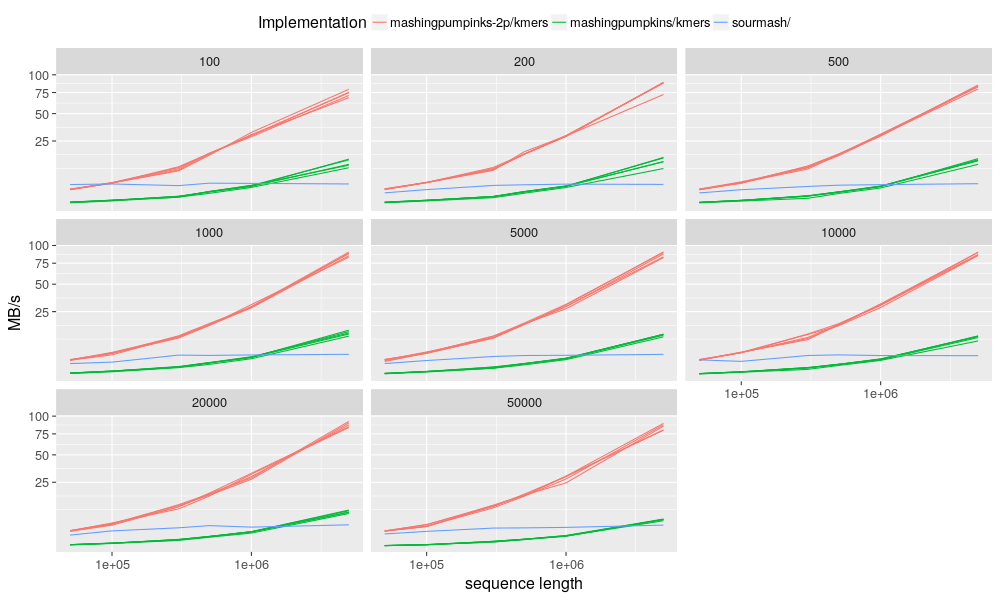

In [34]:
from rpy2.robjects.lib import dplyr, ggplot2 as ggp
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
from rpy2.robjects import Formula

d = dict((n, FloatVector([x[n] for x in res])) for n in ('t',))
d.update((n, StrVector([x[n] for x in res])) for n in ('what', 'hashfun'))
d.update((n, BoolVector([x[n] for x in res])) for n in ('keepngrams', ))
d.update((n, IntVector([x[n] for x in res])) for n in ('l_sequence', 'bufsize', 'sketchsize'))
dataf = dplyr.DataFrame(d)

p = (ggp.ggplot((dataf
                 .filter("hashfun != 'xxhash'")
                 .mutate(implementation='paste(what, ifelse(keepngrams, "kmers", ""), sep="/")'))) +
     ggp.geom_line(ggp.aes_string(x='l_sequence', 
                                  y='l_sequence/t/1E6', 
                                  color='implementation',
                                  #lty='bufsize',
                                  #color='keepngrams',
                                  group='paste(implementation, bufsize, keepngrams)'),
                   alpha=1) +
     ggp.facet_wrap(Formula('~sketchsize')) +
     ggp.scale_x_log10('sequence length') +
     ggp.scale_y_sqrt('MB/s') +
     ggp.scale_color_discrete('Implementation') +
     ggp.theme_gray(base_size=16) +
     ggp.theme(legend_position="top"))

import rpy2.ipython.ggplot
rpy2.ipython.ggplot.image_png(p, width=1000, height=600)

The rate (MB/s) with which a sequence is processed seems to strongly depend on the size of the input sequence for the `mashingpumpkins` implementation (suggesting a significant setup cost than is amortized as the sequence is getting longer), and parallelization achieve a significant boost in performance. Our implementation appears to be scaling better with increasing sequence size (relatively faster as the size is increasing).

Within the range of values explored (buffer size 50 to size 1000), the buffer size does not appear to be the strongest factor although smaller buffer sizes seem associated with a slightly lower rate. Unless dire memory restrictions it appears safer to just have the buffer size set to 250 hash values or more.

Keeping the kmers comes with a slight cost for the larger `max_size` values (not shown). Our Python implementation is otherwise holding up quite well. XXHash appears give slightly faster processing rates in the best case, and make no difference with MurmushHash3 in other cases (not shown).

One can also observe that the performance dip for the largest `max_size` value is recovering as the input sequence is getting longer. We verifiy this with a .1GB reference and `max_size` equal to 20,000.

In [13]:
seqsize = int(1E8)
print("generating sequence:")
f = FloatProgress(min=0, max=seqsize)
display(f)
sequencebitpacked = ssl.RAND_bytes(int(seqsize/4))
sequencen = bytearray(int(seqsize))
for i, b in zip(range(0, len(sequencen), 4), sequencebitpacked):
    sequencen[i:(i+4)] = quad[b]
    if i % 1000 == 0:
        f.value += 1000
f.value = i+4
sequencen = bytes(sequencen)

generating sequence:


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [25]:
sketsize = 20000
bufsize = 1000
funname, hashfun = ('murmurhash3', hasharray)
tmp = run_mashingmp(bufsize, sketchsize, sequence, hashfun)


In [26]:
print("%.2f seconds" % tmp['t'])
print("%.2f MB / second" % (tmp['l_sequence']/tmp['t']/1E6))

0.03 seconds
60.01 MB / second


**note:** As much as I'd be happy to see this, and despite the checks done, this still appears too good to be true... 

### Back-of-envelope time

Assuming 2MB bacterial genomes, and achieving the rate of 50MB/s observed for that size of reference, this would allow us to compute the 20,000-kmers signatures for 90,000 bacterial genomes per hour. On a laptop<sup>*</sup> (where this notebook was run).

(*: just a regular laptop, not a transportable workstation)

Assuming a 3GB proverbial human genome, this would mean a human genome processed in ~ 1 second. Not bad.

When considering raw reads from a sequencing run, this would put the 15E9 bases optimally out of a latest
Illumina MiSeq sequencer processed in under 15 seconds.

I/O and parsing are not included<sup>*</sup>, but this is quite promising... and this is still in Python so customization and ideas can be implemented rather easily and quickly.

(*: this is mean to be a general Python library for MinHashing - parsing data formats is not the focus)